In [1]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pint
import plotly.express as px
import plotly.graph_objects as go
import xarray as xr
from dask.distributed import Client
from pint import UnitStrippedWarning
from seapopym.configuration.no_transport.parameter import ForcingParameters
from seapopym.configuration.parameters.parameter_forcing import ForcingUnit
from seapopym.standard.units import StandardUnitsLabels

from seapopym_optimization import Observation, constraint, wrapper
from seapopym_optimization.cost_function import NoTransportCostFunction
from seapopym_optimization.functional_groups import FunctionalGroupOptimizeNoTransport, Parameter
from seapopym_optimization.genetic_algorithm import GeneticAlgorithm, GeneticAlgorithmParameters
from seapopym_optimization.taylor_diagram import ModTaylorDiagram, generate_mod_taylor_diagram

warnings.simplefilter("ignore", category=UnitStrippedWarning)

In [2]:
path_to_forcing = "../../../1_data_processing/1_1_Forcing/1_optional_extract_barents_sea/Barents_sea_forcing.zarr"
path_to_obs = "../../../1_data_processing/1_1_Forcing/1_optional_extract_barents_sea/zoo_1987_1999.zarr"
export_file_name = "SeapoPym_BARENTS_1999_climato_vgpm_opti_all_parameters_1_group"

In [3]:
LATITUDE = 72
LONGITUDE = 20
TIME_START = "1998-01-01"
TIME_END = "1999-12-01"
SAVE = True

## Loading


### Forcing


In [4]:
forcing = xr.open_zarr(path_to_forcing)
forcing = forcing.sel(time=slice(TIME_START, TIME_END))
forcing["T"].attrs["units"] = StandardUnitsLabels.temperature.units
forcing.load()

<xarray.Dataset> Size: 34kB
Dimensions:              (depth: 1, latitude: 1, longitude: 1, time: 700)
Coordinates:
  * depth                (depth) int64 8B 0
  * latitude             (latitude) int64 8B 72
  * longitude            (longitude) int64 8B 20
  * time                 (time) datetime64[ns] 6kB 1998-01-01 ... 1999-12-01
Data variables:
    T                    (depth, latitude, longitude, time) float64 6kB 5.206...
    npp                  (latitude, longitude, time) float64 6kB 3.654e-06 .....
    pelagic_layer_depth  (latitude, longitude, time) float64 6kB 300.7 ... 273.0
    zeu                  (latitude, longitude, time) float64 6kB 100.2 ... 90.99
    zooc                 (latitude, longitude, time) float64 6kB 0.8288 ... 0...
Attributes:
    Conventions:  CF-1.7
    history:      Created on 2024-10-17
    institution:  CLS
    references:   http://www.cls.fr; http://www.seapodym.eu
    source:       SEAPODYM-LMTL 3.0.0
    title:        Global ocean low and mid trophic levels biomass content hin...

### Epipelagic layer


In [5]:
epi_layer_depth = forcing["pelagic_layer_depth"].load()
epi_layer_depth = epi_layer_depth.resample(time="1D").mean()
epi_layer_depth.attrs["units"] = "meter"
epi_layer_depth = epi_layer_depth.pint.quantify()
epi_layer_depth

<xarray.DataArray 'pelagic_layer_depth' (latitude: 1, longitude: 1, time: 700)> Size: 6kB
<Quantity([[[300.69840118 301.51403941 302.39143112 303.40790242 304.35367045
   305.08424101 305.77766999 306.53938579 307.2823518  308.06688954
   308.91264378 309.7385295  310.46757861 311.14847789 311.66389574
   312.20938485 312.88827043 313.60868299 314.17193742 314.75201743
   315.40025001 315.8469783  316.22935766 316.66825488 317.06338768
   317.43408758 317.8488204  318.23648013 318.53965394 318.78711537
   318.98499501 319.06312659 319.04943343 319.03318958 318.9913046
   319.04401881 319.19750754 319.26579437 319.26919528 319.26910578
   319.25134047 319.17822077 319.03189186 318.80282223 318.28346648
   317.86998663 317.20327275 316.42978799 315.89302491 314.71948497
   312.92997641 311.87667676 311.1581884  309.88432143 307.57102697
   306.25849694 306.03998805 304.36172525 301.81694472 300.07938963
   298.62728778 296.70550146 294.03994364 290.96390416 287.6771421
   283.87939233 279.82912451 274.79424662 269.16877272 262.58996822
   257.11270269 252.64989475 246.09158525 240.12570646 234.39225346
   233.16501484 226.8264672  220.81445229 217.16947527 211.83164731
   200.24772294 193.27351715 189.32814076 185.23406376 181.92036286
   174.39306065 173.23916548 168.86939051 174.29425508 173.65273483
   172.28623763 172.0369415  182.46849216 195.02454166 193.47502145
   193.76982722 196.57858151 198.1310999  195.67953133 193.27302491
...
   155.05616536 155.44440683 155.27172082 150.41785223 143.92371266
   136.26023954 123.7747143  141.83998006 123.62990686 125.07950277
   131.1458876  138.21335009 143.15376306 150.80716767 142.17608906
   141.18628811 133.92237793 140.27748267 128.65019661 114.95278163
   129.57690161 129.04121251 129.82029089 134.74795042 136.781251
   135.52165892 148.61380027 161.79445494 164.71364953 151.96755144
   149.20001088 149.30145664 146.47247584 148.71206886 151.64634382
   156.03867224 159.2381292  157.23579485 156.2910113  156.8591881
   157.64457607 160.45248014 161.65309316 160.57956702 160.29975214
   163.63206858 168.75026893 172.04155063 173.93787483 175.4949576
   177.5927861  179.59570218 178.97270798 179.46315594 181.13484065
   181.25731839 182.87696013 184.8335611  186.55634905 188.17384284
   189.05056332 189.20136712 188.9944482  190.30952891 192.68958874
   194.10629421 195.75551497 198.29913202 200.83375455 203.09965992
   205.28345106 207.13095421 209.31219466 212.21630887 215.56357144
   218.38695863 220.87956194 223.78255742 226.79156305 229.441235
   232.07739279 234.78273237 237.32697591 240.00112552 242.84277025
   245.48420841 247.89049109 250.30482857 252.77984556 255.17753644
   257.31340151 259.4809488  261.54884028 263.34765662 265.02569568
   266.58130174 268.08571506 269.58650371 271.25818842 272.97408505]]], 'meter')>
Coordinates:
  * latitude   (latitude) int64 8B 72
  * longitude  (longitude) int64 8B 20
  * time       (time) datetime64[ns] 6kB 1998-01-01 1998-01-02 ... 1999-12-01
Attributes:
    standard_name:  sea_water_pelagic_layer_bottom_depth

<!-- ## Observed NPP -->


### Observations


In [43]:
with xr.set_options(keep_attrs=True):
    observations = xr.open_zarr(path_to_obs).load()
    # observations = observations.sel(latitude=LATITUDE, longitude=LONGITUDE, method="nearest")
    observations = observations.resample(time="1D").mean().dropna("time")
    observations = observations.pint.quantify().pint.to("mg/m^2").pint.dequantify()
    observations = (
        observations.mean("latitude")
        .expand_dims({"latitude": [LATITUDE]})
        .transpose("time", "latitude", "longitude", "layer")
    )
    observations.latitude.attrs = forcing.latitude.attrs
    # observations = observations * epi_layer_depth
    # observations = observations.drop_vars("depth")
observations

<xarray.Dataset> Size: 3kB
Dimensions:    (latitude: 1, time: 156, longitude: 1, layer: 1)
Coordinates:
  * latitude   (latitude) int64 8B 72
  * layer      (layer) int64 8B 0
  * longitude  (longitude) int64 8B 20
  * time       (time) datetime64[ns] 1kB 1987-01-01 1987-02-01 ... 1999-12-01
Data variables:
    night      (time, latitude, longitude, layer) float64 1kB 1.16e+03 ... 1....

Remove the 6 first months to let the model reach the stationary state.


In [45]:
observations_selected = observations.sel(time=slice(TIME_START, TIME_END))
observations_selected = observations_selected.isel(time=slice(5, None))
observations_selected

<xarray.Dataset> Size: 328B
Dimensions:    (latitude: 1, time: 19, longitude: 1, layer: 1)
Coordinates:
  * latitude   (latitude) int64 8B 72
  * layer      (layer) int64 8B 0
  * longitude  (longitude) int64 8B 20
  * time       (time) datetime64[ns] 152B 1998-06-01 1998-07-01 ... 1999-12-01
Data variables:
    night      (time, latitude, longitude, layer) float64 152B 3.92e+03 ... 1...

Create structure for SeapoPym simulation.


In [8]:
forcing_parameters = ForcingParameters(
    temperature=ForcingUnit(forcing=forcing["T"], resolution=1 / 12, timestep=1),
    primary_production=ForcingUnit(forcing=forcing["npp"], resolution=1 / 12, timestep=1),
)

2025-01-27 10:37:16,803 :: Seapodym ::  WARNING ::
|	npp unit is milligram / day / meter ** 2, it will be converted to kilogram / day / meter ** 2.



## Setup the parameters and the cost function


In [9]:
functional_groups = [
    FunctionalGroupOptimizeNoTransport(
        name="TOTAL",
        day_layer=0,
        night_layer=0,
        energy_coefficient=Parameter("TOTAL_energy_coefficient", 0.001, 0.4),
        tr_rate=Parameter("TOTAL_tr_rate", -0.3, -0.001),
        tr_max=Parameter("TOTAL_tr_max", 0, 50),
        inv_lambda_rate=Parameter("TOTAL_inv_lambda_rate", -0.3, -0.001),
        inv_lambda_max=Parameter("TOTAL_inv_lambda_max", 0, 500),
    ),
]
# [1, 1, 0.1668, 10.38, -0.11, 150, 0.15]

In [10]:
cost_function = NoTransportCostFunction(
    functional_groups=functional_groups,
    forcing_parameters=forcing_parameters,
    observations=[Observation(observations)],
)

Set the genetic algorithm meta parameters.


In [11]:
genetic_algo_parameters = GeneticAlgorithmParameters(
    MUTPB=0.15,
    INDPB=0.1,
    ETA=5,
    CXPB=0.7,
    NGEN=15,
    POP_SIZE=700,
    cost_function_weight=(-1,),
)

Finaly, create the Genetic Algorithm.


In [12]:
client = Client()
genetic_algo = GeneticAlgorithm(
    cost_function=cost_function,
    parameter_genetic_algorithm=genetic_algo_parameters,
    client=client,
)

And watch the magic on the Dask dashboard :


In [13]:
genetic_algo.client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 12,Total memory: 48.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:56468,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 12
Started: Just now,Total memory: 48.00 GiB
Comm: tcp://127.0.0.1:56482,Total threads: 3
Dashboard: http://127.0.0.1:56485/status,Memory: 12.00 GiB
Nanny: tcp://127.0.0.1:56471,


## Run the optimization


In [14]:
viewer = genetic_algo.optimize()

,mean,std,min,max,valid,from_previous_generation
generation,,,,,,
0,15.950731,30.325671,0.382649,245.894801,700,0.000000
1,4.357880,7.998486,0.382649,78.165521,700,0.251429
2,4.172524,10.280752,0.382810,120.570804,700,0.240000
3,2.703633,6.832810,0.373587,100.335964,700,0.215714
4,1.921595,4.488922,0.360672,57.842565,700,0.242857
5,1.918581,5.863717,0.360672,71.350452,700,0.247143
6,1.270752,3.666993,0.360672,69.447061,700,0.247143
7,0.967994,2.598472,0.353986,52.933394,700,0.202857
8,0.663872,0.784793,0.354396,7.957714,700,0.262857


Generations: 100%|██████████| 15/15 [10:22<00:00, 41.51s/it]


## Optimization statistics


In [15]:
viewer.hall_of_fame

TOTAL_energy_coefficient  TOTAL_tr_max  TOTAL_tr_rate  \
generation individual                                                          
14         622                         0.311064      9.695413      -0.182754   
10         632                         0.283991      1.230471      -0.102464   
           429                         0.347365      9.695413      -0.184048   
14         32                          0.347365      9.695413      -0.184048   
13         553                         0.347365      9.695413      -0.184048   
...                                         ...           ...            ...   
0          658                         0.364521     43.092881      -0.263269   
           592                         0.393501     24.197219      -0.032524   
           265                         0.392086     10.069329      -0.254275   
           597                         0.395199     36.071524      -0.102481   
           112                         0.398783     48.083693      -0.216367   

                       TOTAL_inv_lambda_max  TOTAL_inv_lambda_rate     fitness  
generation individual                                                           
14         622                   208.811449              -0.299256    0.350395  
10         632                   235.512454              -0.298607    0.350415  
           429                   188.041579              -0.299538    0.350618  
14         32                    188.041579              -0.299538    0.350618  
13         553                   188.041579              -0.299538    0.350618  
...                                     ...                    ...         ...  
0          658                   406.235149              -0.010271  178.233412  
           592                   417.654626              -0.031471  185.803891  
           265                   477.772535              -0.027852  226.949356  
           597                   464.860822              -0.013583  233.933602  
           112                   438.497988              -0.001071  245.894801  

[8128 rows x 6 columns]

In [16]:
viewer.fitness_evolution()

In [17]:
viewer.box_plot(3, nbest=1000)

In [18]:
fig = viewer.parallel_coordinates(1000, unselected_opacity=0)
fig

In [19]:
if SAVE:
    fig.write_html(f"Parallel_coordinates_{export_file_name}.html")

# Prepare results for ploting


## Run simulation with original parameters


In [20]:
original_config = [[0, 0, 0.1668, 10.38, -0.11, 150, -0.15]]
print(f"Original configuration: {list(original_config[0])}")

Original configuration: [0, 0, 0.1668, 10.38, -0.11, 150, -0.15]


In [21]:
original_model = wrapper.model_generator_no_transport(
    forcing_parameters=forcing_parameters,
    fg_parameters=wrapper.FunctionalGroupGeneratorNoTransport(parameters=original_config, groups_name=["Total"]),
)

original_model.run()

## Run simulation with optimized parameters


In [23]:
best_individual = cost_function.functional_groups.generate_matrix(viewer.hall_of_fame.iloc[0])
print(f"Best individual: {list(best_individual[0])}")

Best individual: [0.0, 0.0, 0.3110641810990331, 9.695412976883794, -0.18275416000059774, 208.81144912859895, -0.2992555440860819]


In [25]:
best_model = wrapper.model_generator_no_transport(
    forcing_parameters=forcing_parameters,
    fg_parameters=wrapper.FunctionalGroupGeneratorNoTransport(parameters=best_individual, groups_name=["Total"]),
)

best_model.run()

And with the X best individuals :


In [27]:
NB_INDIVIDUAL_TO_SHOW = 50

min_biomass_D1N1 = best_model.export_biomass().sel(functional_group=0).data.flatten()
max_biomass_D1N1 = best_model.export_biomass().sel(functional_group=0).data.flatten()


for cpt in range(1, NB_INDIVIDUAL_TO_SHOW):
    individual = cost_function.functional_groups.generate_matrix(viewer.hall_of_fame.iloc[cpt])
    model = wrapper.model_generator_no_transport(
        forcing_parameters=forcing_parameters,
        fg_parameters=wrapper.FunctionalGroupGeneratorNoTransport(parameters=individual, groups_name=["Total"]),
    )
    model.run()
    min_biomass_D1N1 = np.min([model.export_biomass().sel(functional_group=0).data.flatten(), min_biomass_D1N1], axis=0)
    max_biomass_D1N1 = np.max([model.export_biomass().sel(functional_group=0).data.flatten(), max_biomass_D1N1], axis=0)

min_biomass_D1N1 = min_biomass_D1N1 * pint.application_registry(model.export_biomass().attrs["units"])
max_biomass_D1N1 = max_biomass_D1N1 * pint.application_registry(model.export_biomass().attrs["units"])

### Format the results


Convert to pandas series.


In [61]:
optimized_biomass_pandas = (
    best_model.export_biomass()
    .pint.quantify()
    .pint.to("mg/meter^2")
    .pint.dequantify()
    .to_dataframe()
    .pivot_table(index="time", columns="functional_group", values="biomass")
)
original_biomass_pandas = (
    original_model.export_biomass()
    .pint.quantify()
    .pint.to("mg/meter^2")
    .pint.dequantify()
    .to_dataframe()
    .pivot_table(index="time", columns="functional_group", values="biomass")
)
observations_night_pandas = (
    observations.pint.quantify()
    .pint.to("mg/m2")
    .pint.dequantify()
    .night.dropna("time")
    .to_dataframe()
    .reset_index()
    .set_index("time")["night"]
)
layer_pandas = epi_layer_depth.pint.dequantify().to_dataframe().reset_index().set_index("time")["pelagic_layer_depth"]

Then resample to month.


In [62]:
monthly_obs_night = observations_night_pandas.resample("ME").mean()[TIME_START:TIME_END].dropna()
monthly_obs_night.index = monthly_obs_night.index.to_period("M").to_timestamp()

monthly_pred_d1n1 = optimized_biomass_pandas.iloc[:, 0].resample("ME").mean()[TIME_START:TIME_END].dropna()
monthly_pred_d1n1.index = monthly_pred_d1n1.index.to_period("M").to_timestamp()

monthly_pred_orignal = original_biomass_pandas.iloc[:, 0].resample("ME").mean()[TIME_START:TIME_END].dropna()
monthly_pred_orignal.index = monthly_pred_orignal.index.to_period("M").to_timestamp()

monthly_layer = layer_pandas.resample("ME").mean()[TIME_START:TIME_END].dropna()
monthly_layer.index = monthly_layer.index.to_period("M").to_timestamp()

# Plot


### Correlation matrix of X best individuals


In [63]:
NB_INDIVIDUAL_CORRELATION = 100

indiv_param = viewer.hall_of_fame.iloc[:NB_INDIVIDUAL_CORRELATION, :-1].to_numpy()
param_names = viewer.hall_of_fame.columns[:-1]

corr_matrix = np.corrcoef(indiv_param.T)
np.fill_diagonal(corr_matrix, np.nan)

fig = px.imshow(
    corr_matrix,
    text_auto=False,
    aspect="auto",
    color_continuous_scale=[[0, "blue"], [0.5, "white"], [1, "red"]],
    zmin=-1,
    zmax=1,
    x=param_names,
    y=param_names,
)
fig.update_layout(
    title="Correlation Matrix of Hall of Fame Parameters (Lower Triangle)",
    plot_bgcolor="rgba(0,0,0,0)",
    paper_bgcolor="rgba(0,0,0,0)",
    xaxis={"showgrid": False, "tickangle": -35},
    yaxis={"showgrid": False},
)

fig.show()

In [64]:
if SAVE:
    fig.write_html(f"Correlation_best_individuals_{export_file_name}.html")

### Daily with best individuals


In [65]:
x = best_model.export_biomass().time.to_series()
x_rev = pd.concat([x, x[::-1]])
observations_in_range = observations.sel(time=slice(TIME_START, TIME_END))

# D1N1 data
y_D1N1 = (
    best_model.export_biomass()
    .sel(functional_group=0)
    .pint.quantify()
    .pint.to("mg/m2")
    .pint.dequantify()
    .data.flatten()
)
y_D1N1_upper = max_biomass_D1N1.to("milligram / meter ** 2")
y_D1N1_lower = min_biomass_D1N1.to("milligram / meter ** 2")[::-1]
y_D1N1_rev = np.concatenate([y_D1N1_upper, y_D1N1_lower])

fig = go.Figure()

# D1N1 traces
fig.add_trace(
    go.Scatter(
        x=x_rev,
        y=y_D1N1_rev,
        fill="toself",
        fillcolor="rgba(255,0,0,0.2)",
        line_color="rgba(255,255,255,0)",
        name=f"D1N1 : {NB_INDIVIDUAL_TO_SHOW} best individuals",
    )
)

fig.add_trace(
    go.Scatter(
        x=x,
        y=y_D1N1,
        line_color="rgb(255,0,0)",
        name="D1N1 : Best individual",
    )
)

# OBSERVATIONS ------------------------------------------------ #

fig.add_trace(
    go.Scatter(
        x=observations_in_range.night.time.data.flatten(),
        y=observations_in_range.night.pint.quantify().pint.to("mg/m2").pint.dequantify().data.flatten(),
        mode="lines+markers",
        name="Day observations",
        line={"dash": "dash", "color": "firebrick", "width": 1},
    )
)

fig.add_trace(
    go.Scatter(
        x=observations_in_range.night.time.data.flatten(),
        y=observations_in_range.night.pint.quantify().pint.to("mg/m2").pint.dequantify().data.flatten(),
        mode="lines+markers",
        name="Night observations",
        line={"dash": "dash", "color": "royalblue", "width": 1},
    )
)

# PRIMARY PRODUCTION ----------------------------------------- #

fig.add_trace(
    go.Scatter(
        x=best_model.state.primary_production.time.data.flatten(),
        y=best_model.state.primary_production.pint.quantify().pint.to("mg/m2/day").pint.dequantify().data.flatten(),
        mode="lines",
        name="Primary Production (mg/m2/day)",
        line={"dash": "dot", "color": "green", "width": 1},
    )
)

fig.update_layout(
    xaxis_title="Time",
    yaxis_title="Biomass (mg/m2)",
    title=f"Biomass over Time (Daily) : {export_file_name}",
    showlegend=True,
)

fig.show()

In [66]:
if SAVE:
    fig.write_html(f"Biomass_best_individuals_{export_file_name}.html")

### Monthly with original parameters


In [71]:
fig = go.Figure(
    layout={
        "title": "SeapoPym Monthly Biomass during day (CAFE npp) and Observations : HOT station + all param. optimization + 2 groups",
        "xaxis": {"title": "Time"},
        "yaxis": {"title": "Biomass . Epipelagic layer depth (mg/m^2)"},
    }
)

# Night ------------------------------------------------ #
fig.add_trace(
    go.Scatter(
        x=monthly_pred_d1n1.index,
        y=monthly_pred_d1n1,
        mode="lines",
        line={"color": "rgb(0,176,246)"},
        name="Predictions Night",
    )
)
fig.add_trace(
    go.Scatter(
        x=monthly_obs_night.index,
        y=monthly_obs_night,
        # fill="tonextx",
        # fillcolor="rgba(0,176,246,0.15)",
        mode="lines+markers",
        line={"color": "royalblue", "dash": "dash", "width": 1},
        name="Observations (night)",
    )
)

# LMTL ------------------------------------------------ #
fig.add_trace(
    go.Scatter(
        x=monthly_pred_orignal.index,
        y=monthly_pred_orignal,
        mode="lines",
        line={"color": "grey"},
        name="Predictions Original",
    )
)


# LAYER ------------------------------------------------ #

fig.add_trace(px.line(monthly_layer).data[0])

fig.update_traces(
    yaxis="y2",
    selector={"name": "pelagic_layer_depth"},
    line={"color": "green", "width": 1, "dash": "dot"},
)
fig.update_layout(
    yaxis2={"title": "Layer Depth (m)", "overlaying": "y", "side": "right"},
    height=600,
)
fig.update_layout(legend={"y": 1.0, "x": 1.1})
fig.show()

In [72]:
if SAVE:
    fig.write_html(f"Biomass_monthly_with_original_{export_file_name}.html")

### Taylor Diagram


correlation [0.9298668800023188, 0.890056735690493]
norm STD [1.0966126684468709, 0.8676068251633922]
bias [-0.21465296571794273, -0.3519140302981248]
NRMSE [0.4039204667242661, 0.45640224115867223]
name ['Barents Sea - Optimized', 'Barents Sea - Original']


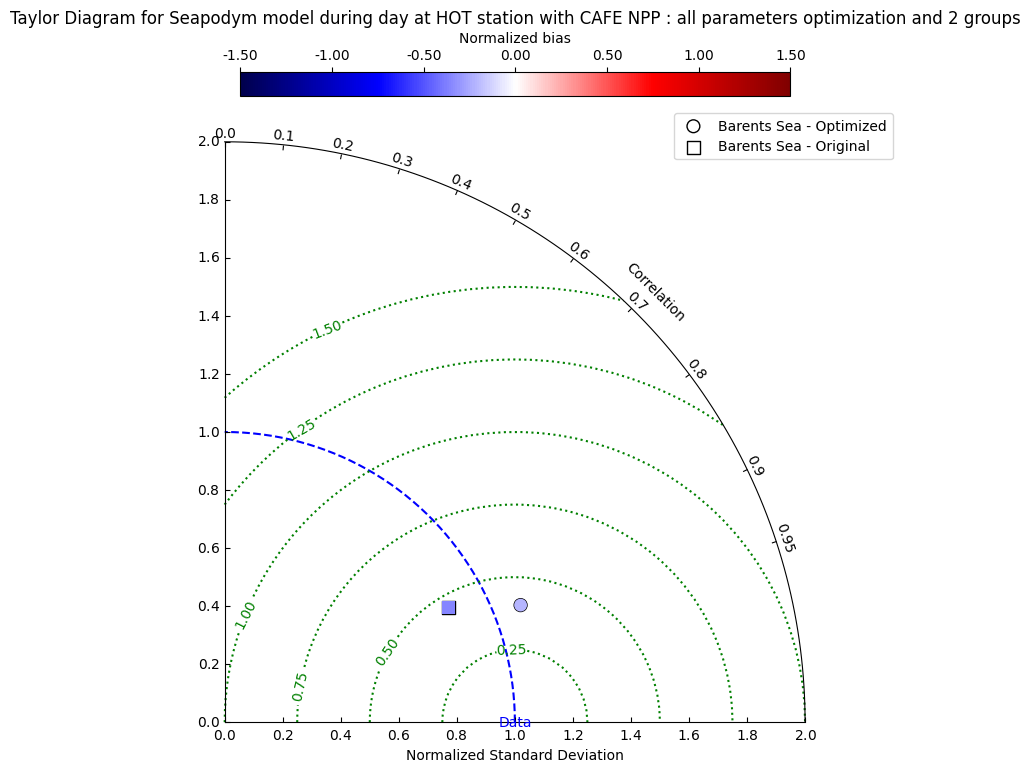

In [73]:
diagram = ModTaylorDiagram()

all_model = [monthly_pred_d1n1, monthly_pred_orignal]
all_obs = [monthly_obs_night, monthly_obs_night]

all_names = ["Barents Sea - Optimized", "Barents Sea - Original"]

for model, obs, name in zip(all_model, all_obs, all_names):
    diagram = generate_mod_taylor_diagram(diagram, obs=obs, model=model[obs.index], name=name)
diagram.plot()
plt.title(
    "Taylor Diagram for Seapodym model during day at HOT station with CAFE NPP : all parameters optimization and 2 groups"
)

# export the figure
if SAVE:
    plt.savefig(f"Taylor_{export_file_name}.png")

plt.show()

In [74]:
if SAVE:
    diagram.get_stats().to_csv(f"Stats_{export_file_name}.csv", index=False)
diagram.get_stats()

,name,correlation_coefficient,normalized_standard_deviation,bias,normalized_root_mean_square_deviation
0,Barents Sea - Optimized,0.929867,1.096613,-0.214653,0.403920
1,Barents Sea - Original,0.890057,0.867607,-0.351914,0.456402
